# OCT-SOX Insert

Take post D2 models, and peaks open exclusively in D2 ("neural-like"). Insert canonical OCT-SOX motifs and see increase in predicted counts.

In [1]:
import numpy as np

In [72]:
import keras
import tensorflow as tf
import pyfaidx
import math
import pandas as pd
import tqdm

In [10]:
import sys

from keras.utils import CustomObjectScope

# mtbatchgen
sys.path.append("/users/surag/kundajelab/mtbatchgen/example/")
from losses import MultichannelMultinomialNLL, multinomial_nll

In [62]:
# local
from importlib import reload
import one_hot
reload(one_hot)

<module 'one_hot' from '/users/surag/kundajelab/scATAC-reprog/src/analysis/20210322_BPNet_synthetic/one_hot.py'>

In [241]:
with CustomObjectScope({'MultichannelMultinomialNLL': MultichannelMultinomialNLL}):
#     model = keras.models.load_model("/srv/scratch/surag/scATAC-reprog/models/cluster_idx8/2020-11-05_07_17_32/SoGro3.h5")
#     model = keras.models.load_model("/srv/scratch/surag/scATAC-reprog/models/cluster_idx2/2020-11-05_03_48_37/QAdERE.h5")
#     model = keras.models.load_model("/srv/scratch/surag/scATAC-reprog/models/cluster_idx4/2021-02-09_18_23_03/0pYOdc.h5")
#     model = keras.models.load_model("/srv/scratch/surag/scATAC-reprog/models/cluster_idx1/2020-11-05_03_48_37/dRMWWH.h5")
    model = keras.models.load_model("/srv/scratch/surag/scATAC-reprog/models/cluster_idx16/2020-11-06_00_34_22/Z21ucK.h5")
#     model = keras.models.load_model("/srv/scratch/surag/scATAC-reprog/models/cluster_idx5/2020-11-05_03_48_37/KR1GbF.h5")

In [27]:
hg38 = pyfaidx.Fasta('/users/surag/genomes/hg38/GRCh38_no_alt_analysis_set_GCA_000001405.15.fasta')

In [213]:
oct_sox_hits = pd.read_csv("./data/20201211_gridmap_peakwidthnorm_logplusznorm_4way_ordered_n20/idx8.200.OCTSOX.thresh7.bed", 
                           sep='\t',
                           names=["chr", "start", "end", "strand", "score", "seq"])
oct_sox_hits.head()

,chr,start,end,strand,score,seq
0,chr1,2350165,2350180,+,7.492762,CTTTGAATATAAAAT
1,chr1,5940748,5940763,+,8.132912,ATCTACATTTTAAAA
2,chr1,7263287,7263302,-,12.820701,CTTTCTTTTGCAAAT
3,chr1,7843523,7843538,-,7.100240,TTTTGTTTTTAAAAT
4,chr1,9756154,9756169,-,7.883148,ATTTCACATGAAAAT


In [218]:
first_seq = oct_sox_hits.iloc[0]
hg38[first_seq['chr']][first_seq['start']:first_seq['end']]

>chr1:2350166-2350180
CTTTGAATATAAAAT

In [219]:
hg38[first_seq['chr']][first_seq['start']:first_seq['end']]==first_seq['seq']

True

In [220]:
oct_sox_hits.shape

(5032, 6)

In [221]:
MODEL_INP_LEN = model.input_shape[0][1]
print(MODEL_INP_LEN)

2346


In [243]:
BATCH_SIZE = 128

# predict on raw sequence
raw_pred_counts = []

for i in tqdm.tqdm(range(math.ceil(oct_sox_hits.shape[0]/BATCH_SIZE))):
    cur_seqs = oct_sox_hits[i*BATCH_SIZE:(i+1)*BATCH_SIZE]
    cur_raw_seqs = []
    for j, r in cur_seqs.iterrows():
        mid = (r['start']+r['end'])//2
        cur_raw_seqs.append(str(hg38[r['chr']][mid-(MODEL_INP_LEN//2):mid+(MODEL_INP_LEN//2)]))
        
    cur_raw_seqs = one_hot.dna_to_one_hot(cur_raw_seqs)
    
    cur_pred = model.predict([cur_raw_seqs, 
                   np.zeros((cur_raw_seqs.shape[0],1)), 
                   np.zeros((cur_raw_seqs.shape[0],2000,2))])[1]
    raw_pred_counts.append(cur_pred)
    
raw_pred_counts = np.vstack(raw_pred_counts).ravel()

100%|██████████| 40/40 [00:21<00:00,  1.84it/s]


In [242]:
BATCH_SIZE = 128

# replace with canonical motif and predict
synth_pred_counts = []

for i in tqdm.tqdm(range(math.ceil(oct_sox_hits.shape[0]/BATCH_SIZE))):
    cur_seqs = oct_sox_hits[i*BATCH_SIZE:(i+1)*BATCH_SIZE]
    cur_raw_seqs = []
    for j, r in cur_seqs.iterrows():
        mid = (r['start']+r['end'])//2
        cur_raw_seqs.append(str(hg38[r['chr']][mid-(MODEL_INP_LEN//2):mid+(MODEL_INP_LEN//2)]))
        
        motif_start = MODEL_INP_LEN//2 - (mid-r['start'])
        motif_end = MODEL_INP_LEN//2 + (r['end']-mid)
        # make sure seqs match
        assert(cur_raw_seqs[-1][motif_start:motif_end] == r['seq'])
        
        # replace with canonical (or something else)
        # OCTSOX: ATTTGCATAACAATG/CATTGTTATGCAAAT
        # OCTonly: ATTTGCATAAAAGAC/GTCTTTTATGCAAAT
        # KLF:  GCCACACCCAAGGAG/CTCCTTGGGTGTGGC
        # random: ACGTAGAATACTGTG
        if r['strand'] == "+":
            replacement = "ATTTGCATAACAATG"
        else:
            replacement = "CATTGTTATGCAAAT" 
        
        cur_raw_seqs[-1] = cur_raw_seqs[-1][:motif_start] +  replacement + cur_raw_seqs[-1][motif_end:] 
        
    cur_raw_seqs = one_hot.dna_to_one_hot(cur_raw_seqs)
    
    cur_pred = model.predict([cur_raw_seqs, 
                   np.zeros((cur_raw_seqs.shape[0],1)), 
                   np.zeros((cur_raw_seqs.shape[0],2000,2))])[1]
    synth_pred_counts.append(cur_pred)
    
synth_pred_counts = np.vstack(synth_pred_counts).ravel()

100%|██████████| 40/40 [00:23<00:00,  1.69it/s]


In [244]:
np.median(synth_pred_counts)

5.13935

In [245]:
np.median(raw_pred_counts)

4.622422

In [246]:
np.exp(np.median(synth_pred_counts-raw_pred_counts))

1.6037955

In [194]:
import scipy.stats

In [195]:
scipy.stats.ttest_rel(raw_pred_counts, synth_pred_counts)

Ttest_relResult(statistic=-19.386177173969415, pvalue=4.1767542280397166e-74)

<AxesSubplot:>

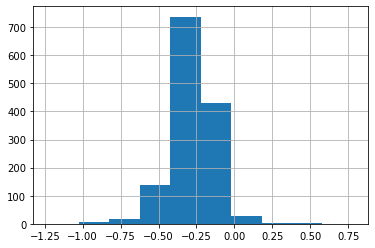

In [150]:
pd.Series(synth_pred_counts-  raw_pred_counts).hist()